In [1]:
from itertools import count
import json
from warnings import simplefilter
import random
import pickle
from collections import defaultdict

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from termcolor import colored, cprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
from scipy import stats

import pymc3 as pm
import arviz as az
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as proportion

for w in (DeprecationWarning, FutureWarning, RuntimeWarning):
    simplefilter(action='ignore', category=w)

plt.rcParams['figure.figsize'] = (15, 8)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Repeated testing
Generate trajectories_h0: at each time step, gather new data, and compute the p-value and a bayesian decision criterion.

The setup is an A/B test with binary outcome.

## Simulate trajectories

In [2]:
def bayesian_analysis(successes_a, n_samples_a, successes_b, n_samples_b,
                      alpha_prior=1, beta_prior=1, alpha=.05, rope=(-.05, .05), resolution=500,
                      return_distributions=False):
    a_rvs = sp.stats.beta.rvs(alpha_prior + successes_a, beta_prior + n_samples_a - successes_a, size=400 * resolution)
    b_rvs = sp.stats.beta.rvs(alpha_prior + successes_b, beta_prior + n_samples_b - successes_b, size=400 * resolution)
    delta = b_rvs - a_rvs
    
    bins = np.linspace(np.min(delta) - 0.2 * abs(np.min(delta)),
                       np.max(delta) + 0.2 * abs(np.max(delta)), resolution)
    pdf, _ = np.histogram(delta, bins=bins, density=True)    
    x = 0.5 * (bins[0:-1] + bins[1:])
    k = np.linspace(0, max(pdf), 1000)
    area_above = np.array([np.trapz(pdf[pdf >= kk], x[pdf >= kk]) for kk in k])
    index = np.argwhere(np.abs(area_above - (1 - alpha)) == np.min(np.abs(area_above - (1 - alpha))))[0]
    hpd = x[pdf >= k[index]]
    
    distributions = {
        'a': a_rvs,
        'b': b_rvs,
        'delta': delta,
    }
    
    return {
        'proba_h0': ((delta >= rope[0]) & (delta <= rope[1])).mean(),
        'proba_ha': (delta < rope[0]).mean(),
        'proba_hb': (delta > rope[1]).mean(),
        'hpd_lower': hpd[0],
        'hpd_upper': hpd[-1],
        **(distributions if return_distributions else {}),
    }

In [3]:
def frequentist_analysis(successes_a, n_samples_a, successes_b, n_samples_b, alpha=0.05):
    _, pvalue = stats.fisher_exact([
        [n_samples_a - successes_a, successes_a],
        [n_samples_b - successes_b, successes_b],
    ])
    ci_lower, ci_upper = proportion.confint_proportions_2indep(successes_b, n_samples_b,
                                                               successes_a, n_samples_a, 
                                                               alpha=alpha, method='newcomb')
    return {
        'pvalue': pvalue,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
    }

In [4]:
def generate_trajectory(prob_a, prob_b, length, step_size, seed=0):
    np.random.seed(seed)
    samples_a = np.array([])
    samples_b = np.array([])
    experiments = []
    for i in tqdm(range(length)):
        samples_a = np.concatenate([samples_a, np.random.binomial(1, prob_a, size=step_size)])
        samples_b = np.concatenate([samples_b, np.random.binomial(1, prob_b, size=step_size)])
        args = {
            'successes_a': samples_a.sum(),
            'successes_b': samples_b.sum(),
            'n_samples_a': len(samples_a),
            'n_samples_b': len(samples_b),
        }
        experiments.append({
            **args, **bayesian_analysis(**args), **frequentist_analysis(**args),
        })
    df = pd.DataFrame(experiments)
    prior = bayesian_analysis(0, 0, 0, 0)
    df['bayes_factor'] = (1 - df.proba_h0) / df.proba_h0 * prior['proba_h0'] / (1 - prior['proba_h0'])
    return df

In [5]:
def plot_trajectory(trajectory):
    plt.subplot(1,2,1)
    trajectory.hpd_upper.plot(label='hpd_upper', color='dodgerblue')
    plt.plot([.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    trajectory.hpd_lower.plot(label='hpd_lower', color='blue')
    plt.plot([-.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    _ = plt.legend()

    plt.subplot(1,2,2)
    trajectory.pvalue.plot(label='pvalue', color='red')
    plt.plot([.05] * len(trajectory), label='pvalue threshold', color='red', linestyle='dashed')
    _ = plt.legend()

In [6]:
try:
    with open('trajectories_h0.pkl', 'rb') as f:
        trajectories_h0 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.3, length=200, step_size=10, seed=seed)

    trajectories_h0 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h0.pkl', 'wb+') as f:
        pickle.dump(trajectories_h0, f)

In [7]:
try:
    with open('trajectories_h1.pkl', 'rb') as f:
        trajectories_h1 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.4, length=200, step_size=10, seed=seed)

    trajectories_h1 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h1.pkl', 'wb+') as f:
        pickle.dump(trajectories_h1, f)

## p-value is meaningless if monitored continuously

In [8]:
def plot_pvalue_trajectories(trajectories, proba_a, proba_b, alpha=.05):
    labels = {
        'green': f'Eventually significant ({sum((traj.pvalue.iloc[-1] <= alpha).sum() for traj in trajectories)})',
        'coral': f'Significant at least once ({sum(((traj.pvalue <= alpha).any()).sum() for traj in trajectories)})',
        'gray': f'Non-significant ({sum(((traj.pvalue > alpha).all()).sum() for traj in trajectories)})',
    }
    plt.yscale('log')
    plt.title(f'p-value evolution across time, '
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Sample size (same for A and B)')
    plt.ylabel('p-value (log scale)')
    plt.plot(trajectories[0].n_samples_a, [alpha] * len(trajectories[0]),
             linestyle='dashed', color='red', label=f'{alpha:.02} threshold')
    for traj in trajectories:
        if traj.pvalue.iloc[-1] <= alpha:
            color = 'green'
        elif (traj.pvalue <= alpha).any():
            color = 'coral'
        else:
            color = 'gray'
        label = labels.get(color)
        transparency = random.random()
        if label:
            transparency = 1
            del labels[color]
        plt.plot(traj.n_samples_a, traj.pvalue, color=color, linewidth=1, label=label, alpha=transparency)
    _ = plt.legend()

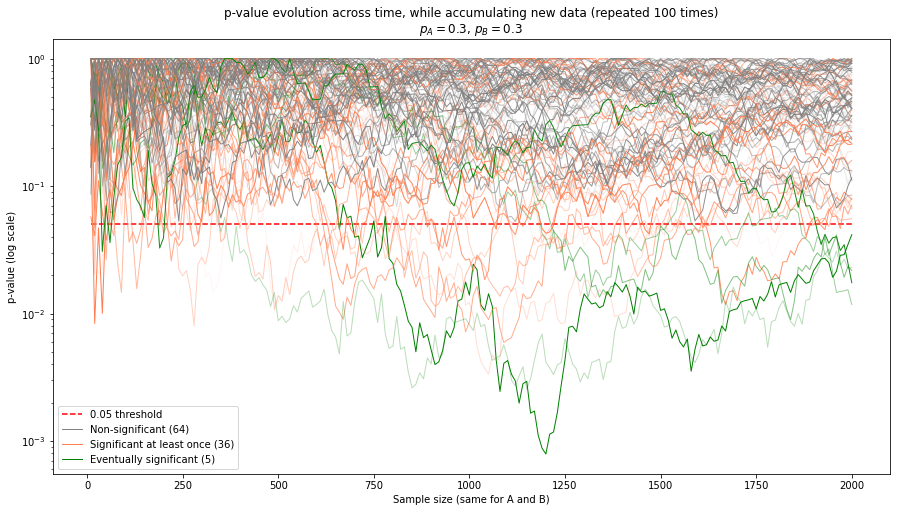

In [9]:
plot_pvalue_trajectories(trajectories_h0, .3, .3)
plt.savefig('figures/repeated_pvalue_h0.png', dpi=300)

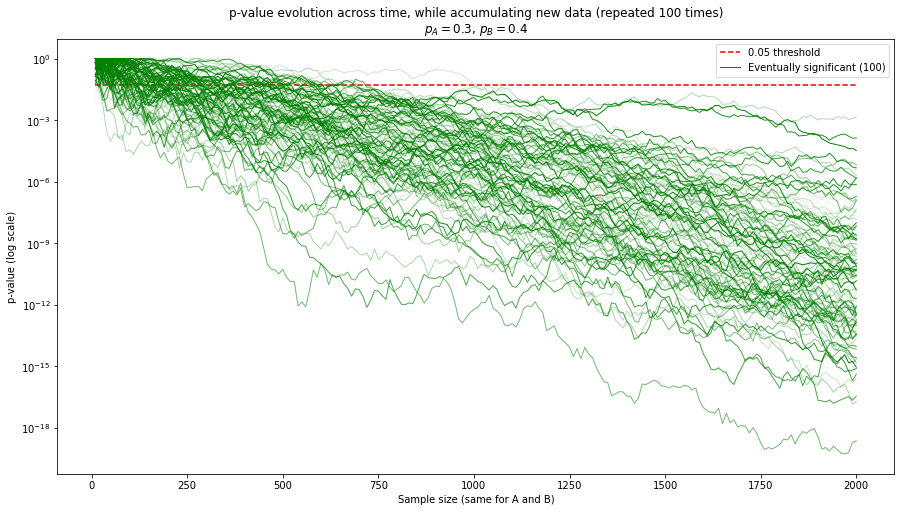

In [10]:
plot_pvalue_trajectories(trajectories_h1, .3, .4)
plt.savefig('figures/repeated_pvalue_h1.png', dpi=300)

## Bayes factor shares multiple caveats with p-values

In [11]:
def plot_bayesian_trajectories(trajectories, proba_a, proba_b):
    labels = {
        'coral': f'Some practical effect mistakenly detected at the beginning ({sum(((traj.bayes_factor >= 3).any()).sum() for traj in trajectories)})',
        'gray': f'No practical effect ({sum(((traj.bayes_factor < 3).all()).sum() for traj in trajectories)})',
    }
    plt.figure(figsize=(15, 8))
    n = len(trajectories[0])
    plt.yscale('log')
    plt.title(f'Bayes factor evolution across time, '
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Sample size (same for A and B)')
    plt.ylabel('Bayes factor against the null hypothesis (log scale)')
    plt.fill_between(range(n), [100] * n, [1000] * n, color='crimson', alpha=.30, label='Decisive')
    plt.fill_between(range(n), [10] * n, [100] * n, color='crimson', alpha=.20, label='Strong')
    plt.fill_between(range(n), [3.2] * n, [10] * n, color='crimson', alpha=.1, label='Substantial')
    plt.fill_between(range(n), [1] * n, [3.2] * n, color='crimson', alpha=.05, label='Not worth more than a bare mention')
    plt.fill_between(range(n), [0] * n, [1] * n, color='white', alpha=0, label='Negative')
    
    for traj in trajectories:
        if (traj.bayes_factor >= 3).any():
            color = 'coral'
        else:
            color = 'darkgray'
        label = labels.get(color)
        alpha = random.random()
        if label:
            alpha = 1
            del labels[color]
        plt.plot(traj.bayes_factor + 1e-4, color=color, linewidth=1, alpha=alpha, label=label)
    _ = plt.legend(loc='lower left')

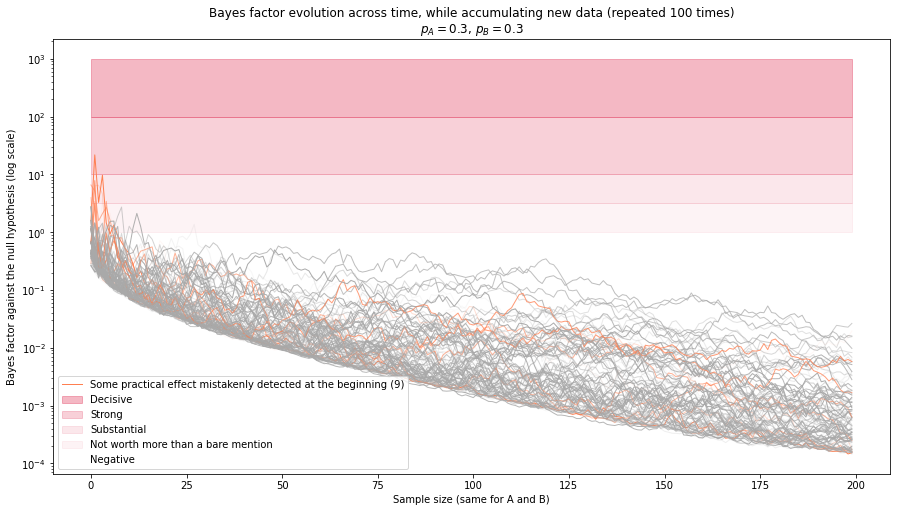

In [12]:
plot_bayesian_trajectories(trajectories_h0, .3, .3)
plt.savefig('figures/repeated_BF_h0.png', dpi=300)

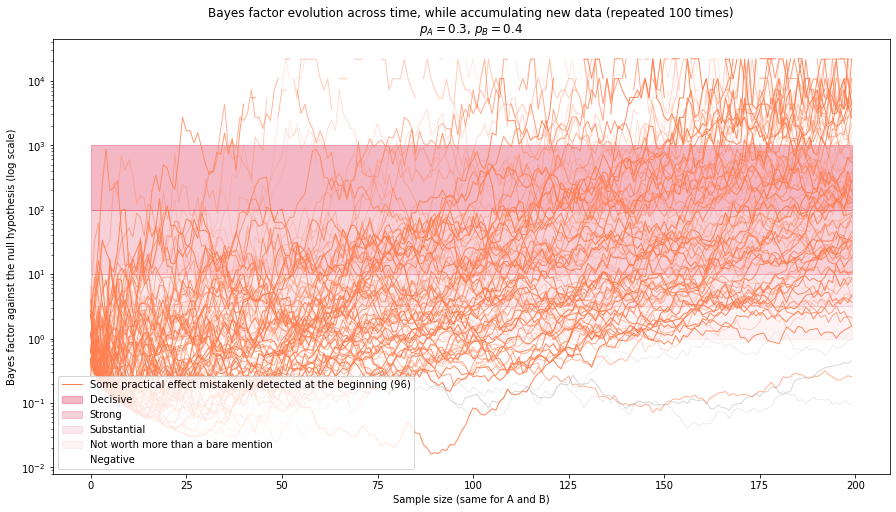

In [13]:
plot_bayesian_trajectories(trajectories_h1, .3, .4)
plt.savefig('figures/repeated_BF_h1.png', dpi=300)

## HDI

In [14]:
def accept_h0(hpd_lower, hpd_upper, rope):
    return (hpd_lower >= rope[0]) & (hpd_upper <= rope[1])

In [15]:
def accept_h1(hpd_lower, hpd_upper, rope):
    return (hpd_lower >= rope[1]) | (hpd_upper <= rope[0])

In [16]:
def is_undecided(hpd_lower, hpd_upper, rope):
    return ~accept_h0(hpd_lower, hpd_upper, rope) & ~accept_h1(hpd_lower, hpd_upper, rope)

In [17]:
def group_by_decision(trajectories, rope):
    grouped = defaultdict(list)
    for traj in trajectories:
        if accept_h1(traj.hpd_lower.iloc[-1], traj.hpd_upper.iloc[-1], rope):
            grouped['accept_h1'].append(traj)
        if accept_h1(traj.hpd_lower, traj.hpd_upper, rope).any():
            grouped['accepted_h1_once'].append(traj)
        if accept_h0(traj.hpd_lower.iloc[-1], traj.hpd_upper.iloc[-1], rope):
            grouped['accept_h0'].append(traj)
        if is_undecided(traj.hpd_lower.iloc[-1], traj.hpd_upper.iloc[-1], rope):
            grouped['undecided'].append(traj)
    return grouped

In [18]:
def plot_trajectory_hdi(traj, rope=(-.05, .05), **kwargs):
    plt.fill_between(traj['n_samples_a'], traj['hpd_lower'], traj['hpd_upper'], alpha=.4, **kwargs)
    if 'label' in kwargs:
        del kwargs['label']
    plt.plot(traj['n_samples_a'], traj['hpd_lower'], linewidth=.5, **kwargs)
    plt.plot(traj['n_samples_a'], traj['hpd_upper'], linewidth=.5, **kwargs)

In [19]:
rope=(-.05, .05)
trajs_by_decision = group_by_decision(trajectories_h0, rope=rope)

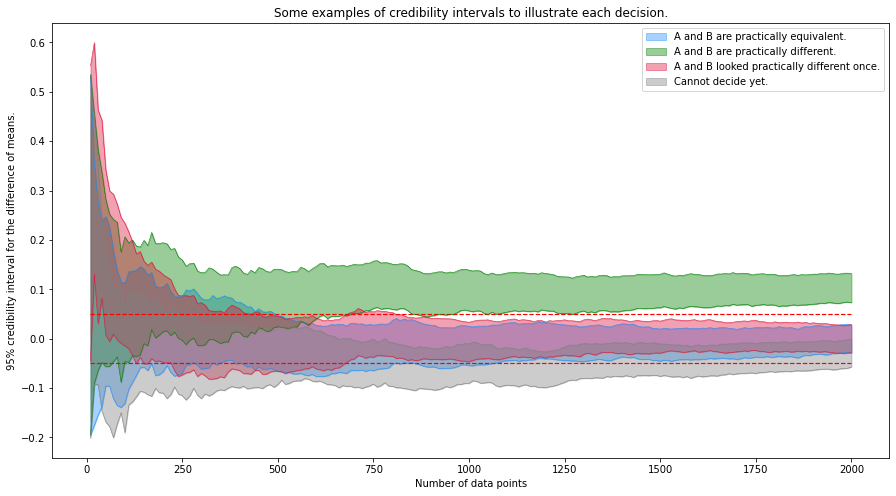

In [20]:
plt.figure(figsize=(15, 8))
plt.title('Some examples of credibility intervals to illustrate each decision.')
plt.xlabel('Number of data points')
plt.ylabel('95% credibility interval for the difference of means.')
plt.hlines(rope,
           trajectories_h0[0].n_samples_a.iloc[0],
           trajectories_h0[0].n_samples_a.iloc[-1], linestyle='dashed', color='red', linewidth=1.2)
plot_trajectory_hdi(trajs_by_decision['accept_h0'][0], color='dodgerblue',
                    label='A and B are practically equivalent.')
plot_trajectory_hdi(trajectories_h1[0], color='green',
                    label='A and B are practically different.')
plot_trajectory_hdi(trajs_by_decision['accepted_h1_once'][0], color='crimson',
                   label='A and B looked practically different once.')
plot_trajectory_hdi(trajs_by_decision['undecided'][0], color='gray',
                   label='Cannot decide yet.')
_ = plt.legend()
plt.savefig('figures/ROPE_examples_decisions_time.png', dpi=300)

## ROPE decisions

In [21]:
def plot_rope_decisions(trajectories, proba_a, proba_b, rope=(-.05, .05), accumulate=True):
    plt.title(f'ROPE decision evolution across time,\n'
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Number of data points')
    plt.ylabel('Number of cases for each decision')
    n_samples = trajectories[0].n_samples_a
    counts_h1 = np.sum([accept_h1(traj.hpd_lower, traj.hpd_upper, rope) for traj in trajectories], axis=0)
    if accumulate:
        counts_h1_cum = np.sum(np.maximum.accumulate([accept_h1(traj.hpd_lower, traj.hpd_upper, rope)
                                                      for traj in trajectories], axis=1), axis=0)
    counts_h0 = np.sum([accept_h0(traj.hpd_lower, traj.hpd_upper, rope) for traj in trajectories], axis=0)
    counts_undecided = len(trajectories) - counts_h1 - counts_h0 
    plt.plot(n_samples, counts_h1, label='A or B is practically better.', color='darkgreen')
    if accumulate:
        plt.plot(n_samples, counts_h1_cum, label='A or B looked practically better\nat least once.', color='green', linestyle='dashed')
    plt.plot(n_samples, counts_h0, label='A and B are practically equivalent.', color='dodgerblue')
    plt.plot(n_samples, counts_undecided, label='Undecided', color='gray')

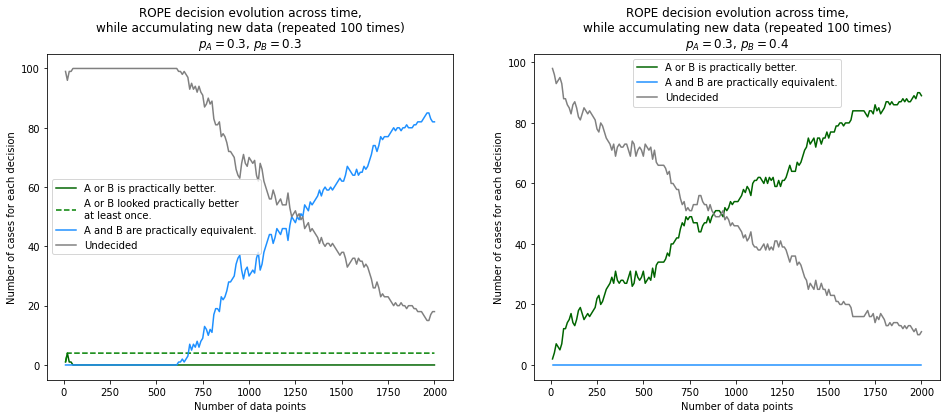

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plot_rope_decisions(trajectories_h0, .3, .3)
_ = plt.legend(loc="center left")
plt.subplot(1,2,2)
plot_rope_decisions(trajectories_h1, .3, .4, accumulate=False)
_ = plt.legend()
plt.savefig('figures/decision_counts_rope_h0_h1.png', dpi=300)

In [23]:
def plot_pvalue_decisions(trajectories, proba_a, proba_b, alpha=.05, accumulate=True):
    plt.title(f'p-value decision evolution across time,\n'
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Number of data points')
    plt.ylabel('Number of cases for each decision')
    n_samples = trajectories[0].n_samples_a
    counts_h1 = np.sum([traj.pvalue < alpha for traj in trajectories], axis=0)
    if accumulate:
        counts_h1_cum = np.sum(np.maximum.accumulate([traj.pvalue < .05 for traj in trajectories], axis=1), axis=0)
    counts_h0 = np.sum([traj.pvalue >= alpha for traj in trajectories], axis=0)
    plt.plot(n_samples, counts_h1, label='Reject the null hypothesis.', color='darkgreen')
    if accumulate:
        plt.plot(n_samples, counts_h1_cum, label='Reject the null hypothesis at least once.', color='green', linestyle='dashed')
    plt.plot(n_samples, counts_h0, label='Cannot reject the null hypothesis.', color='gray')
    _ = plt.legend()

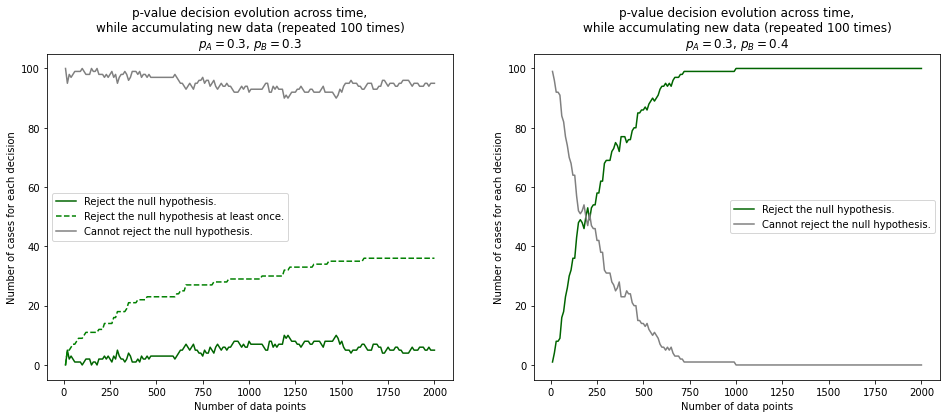

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plot_pvalue_decisions(trajectories_h0, .3, .3)
_ = plt.legend(loc="center left")
plt.subplot(1,2,2)
plot_pvalue_decisions(trajectories_h1, .3, .4, accumulate=False)
plt.savefig('figures/decision_counts_pvalue_h0_h1.png', dpi=300)

# Multiple comparisons
One reference (aka control) group is compared to 10 different experimental (aka treatment) groups.

In [25]:
np.random.seed(12)
sample_groups = [np.random.binomial(1, .3, size=5000) for i in range(11)]
for samples in sample_groups:
    print(samples.mean(), end=' ')

0.2928 0.3002 0.3092 0.3066 0.2922 0.3004 0.3124 0.2942 0.2926 0.2928 0.3032 

In [26]:
with pm.Model() as model:
    kappa_minus_two = pm.Gamma("kappa_minus_two", alpha=1, beta=2)
    omega = pm.Beta("omega", alpha=1, beta=1)
    alpha = pm.Deterministic("alpha", omega * kappa_minus_two + 1)
    beta = pm.Deterministic("beta", (1 - omega) * kappa_minus_two + 1)
    
    proba = []
    observed = []
    for i, samples_i in enumerate(sample_groups):
        proba_i = pm.Beta(f"proba_{i}", alpha=alpha, beta=beta)
        observed_i = pm.Bernoulli(f"observed_{i}", p=proba_i, observed=samples)
        proba.append(proba_i)
        observed.append(observed_i)

    difference = []
    for i in range(1, len(proba)):
        difference_i = pm.Deterministic(f"difference_0-{i}", proba[0] - proba[i])

In [27]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [proba_10, proba_9, proba_8, proba_7, proba_6, proba_5, proba_4, proba_3, proba_2, proba_1, proba_0, omega, kappa_minus_two]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


/home/thomas/bayesian-sandbox/venv/lib/python3.8/site-packages/arviz/plots/traceplot.py:197: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


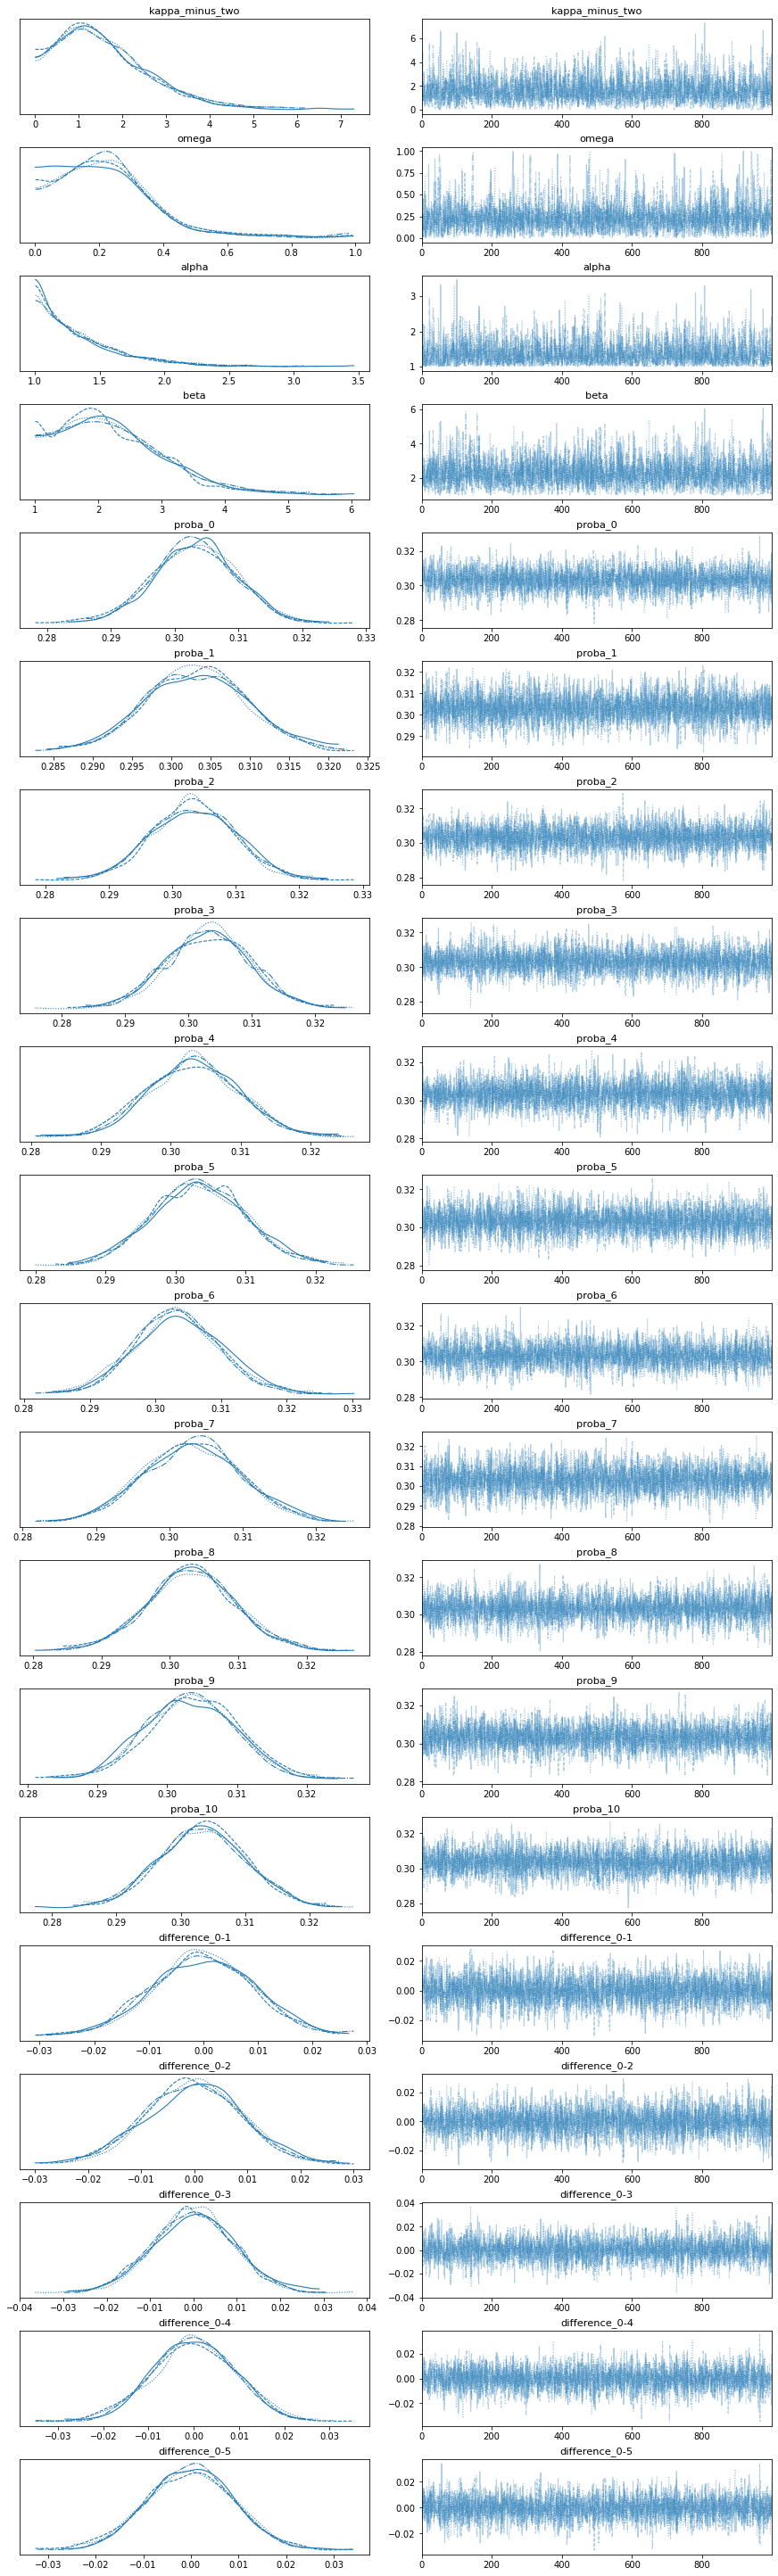

In [28]:
with model:
    pm.plot_trace(trace)

array([[<AxesSubplot:xlabel='observed_0'>,
        <AxesSubplot:xlabel='observed_1'>,
        <AxesSubplot:xlabel='observed_2'>],
       [<AxesSubplot:xlabel='observed_3'>,
        <AxesSubplot:xlabel='observed_4'>,
        <AxesSubplot:xlabel='observed_5'>],
       [<AxesSubplot:xlabel='observed_6'>,
        <AxesSubplot:xlabel='observed_7'>,
        <AxesSubplot:xlabel='observed_8'>],
       [<AxesSubplot:xlabel='observed_9'>,
        <AxesSubplot:xlabel='observed_10'>, <AxesSubplot:>]], dtype=object)

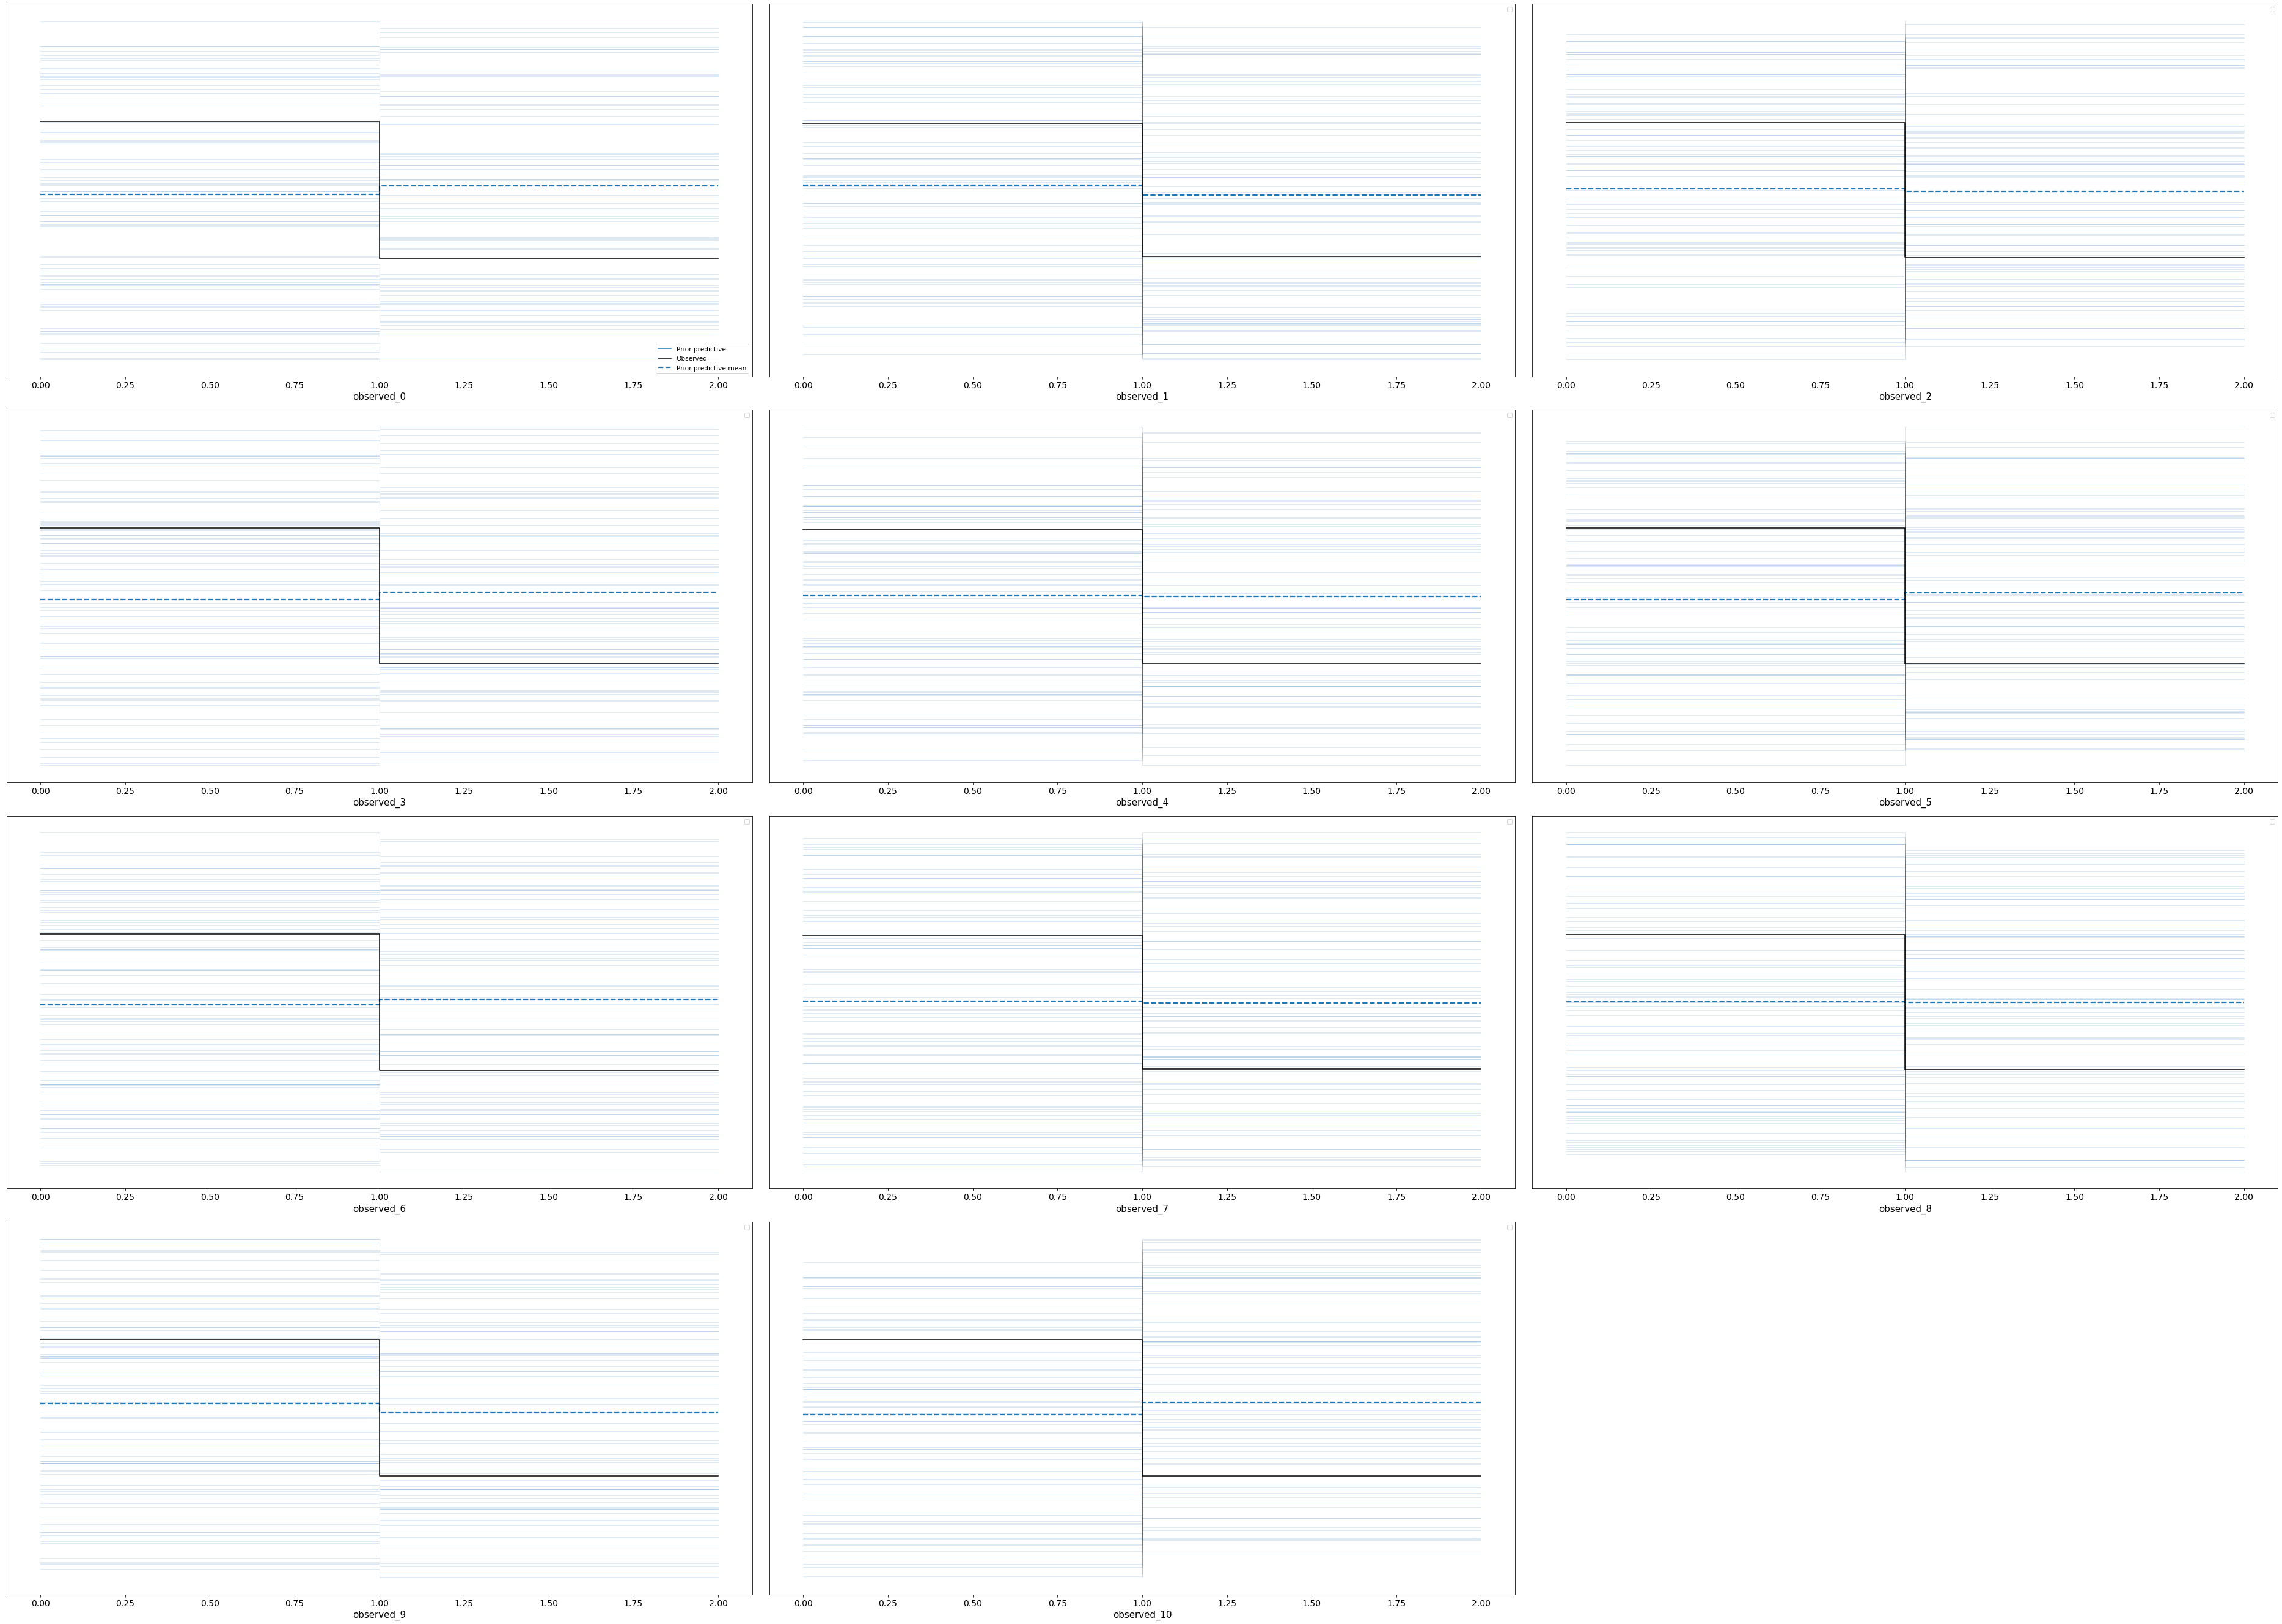

In [29]:
with model:
    prior_predictive = pm.sample_prior_predictive()
az.plot_ppc(az.from_pymc3(prior=prior_predictive, model=model), num_pp_samples=100, group="prior")

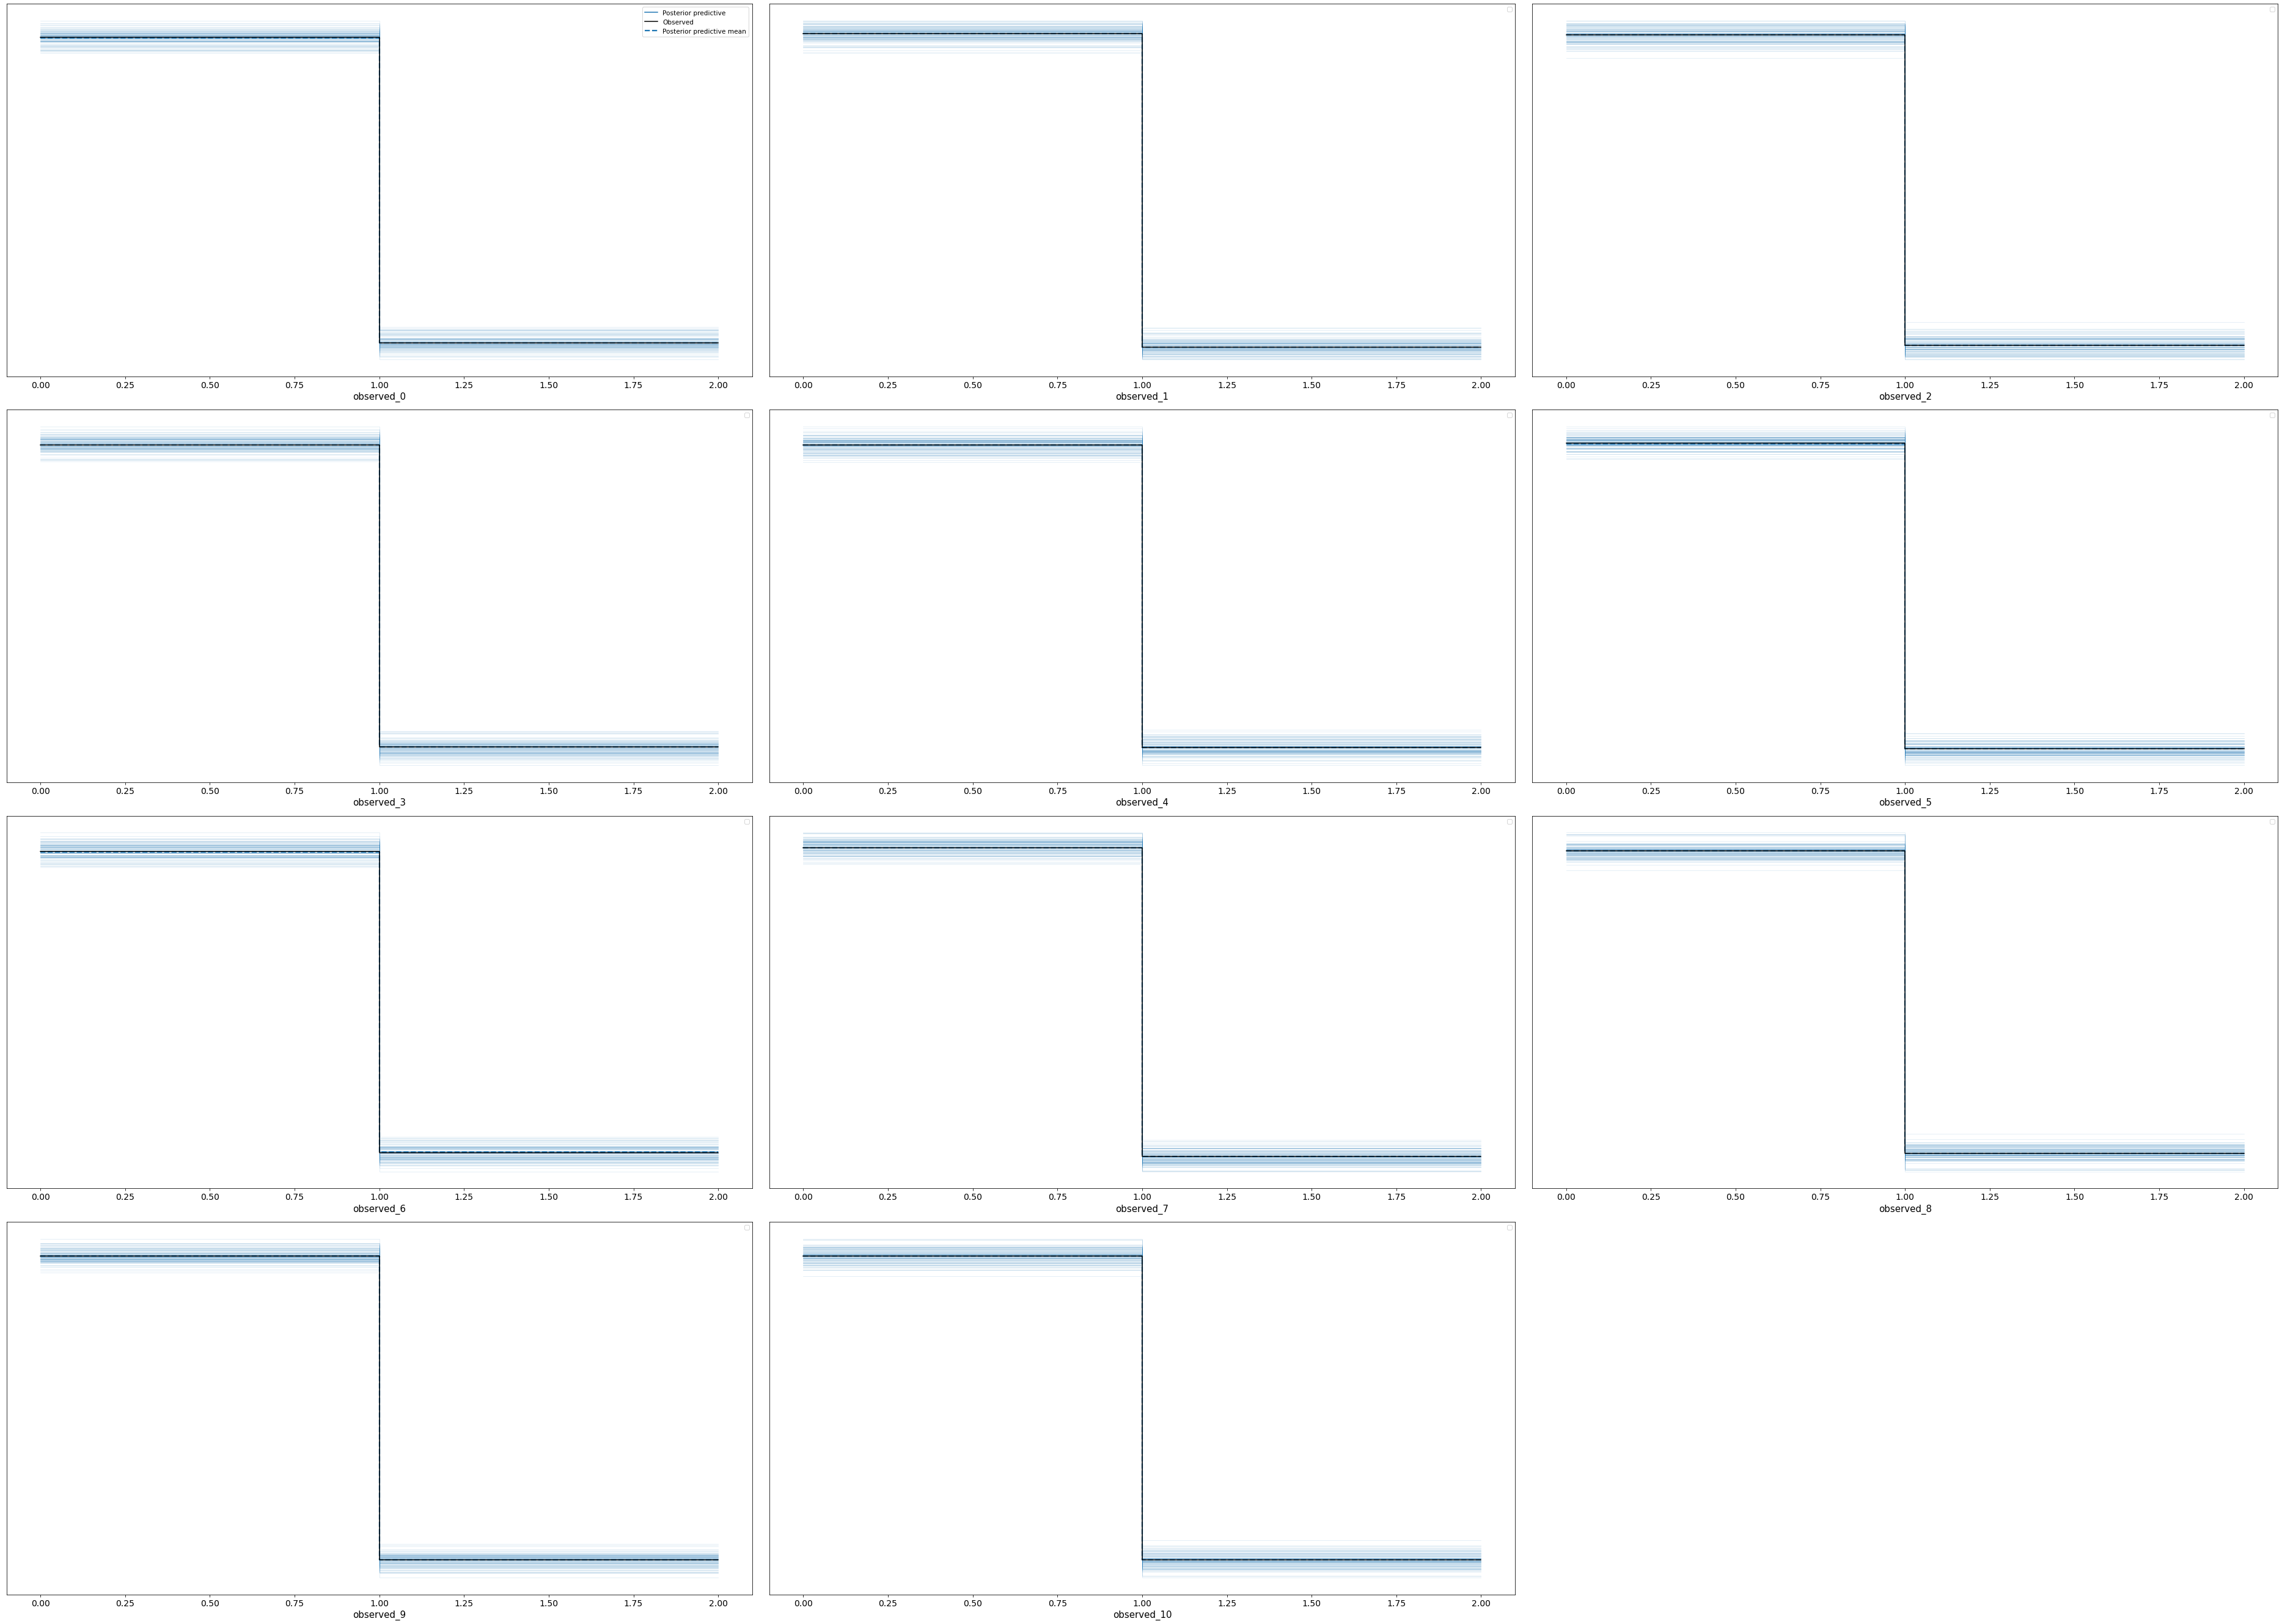

In [30]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)
_ = az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_predictive, model=model),
                num_pp_samples=100, alpha=.15)

In [31]:
hdis = pm.hdi(trace, var_names=[f"difference_0-{i}" for i in range(1, len(sample_groups))])

In [32]:
cis = [frequentist_analysis(sample_groups[0].sum(), len(sample_groups[0]),
                            sample_groups[i].sum(), len(sample_groups[i])) for i in range(1, len(sample_groups))]

In [33]:
intervals = pd.DataFrame(cis, index=[f'difference_0-{i}' for i in range(1, len(sample_groups))])\
              .join(hdis.to_dataframe().transpose()) \
              .rename(columns={'lower': 'hdi_lower', 'higher': 'hdi_upper'})

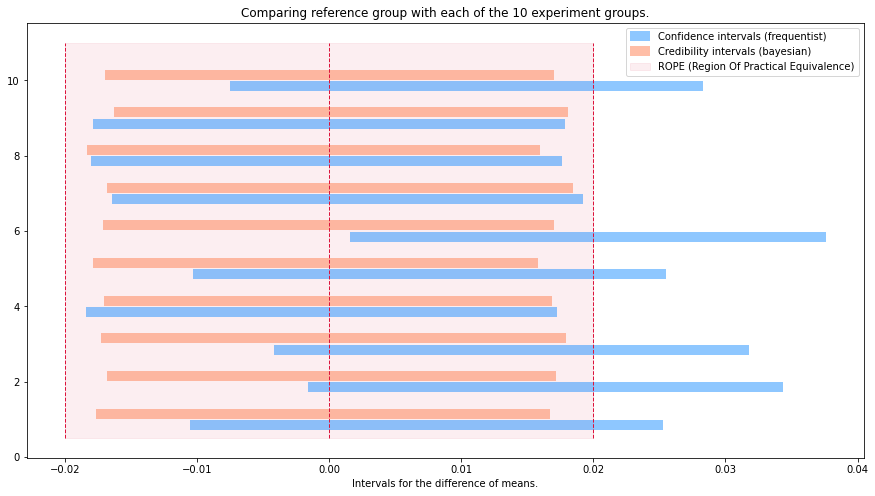

In [34]:
plt.title('Comparing reference group with each of the 10 experiment groups.')
plt.xlabel('Intervals for the difference of means.')
y = np.arange(1, len(intervals) + 1)
plt.hlines(y - .15, intervals.ci_lower, intervals.ci_upper, linewidth=10, alpha=.5, color='dodgerblue',
          label='Confidence intervals (frequentist)')
plt.hlines(y + .15, intervals.hdi_lower, intervals.hdi_upper, linewidth=10, alpha=.5, color='coral',
          label='Credibility intervals (bayesian)')
plt.vlines([-.02, 0, .02], y[0] - .5, y[-1] + 1, color='crimson', linestyle='dashed', linewidth=1)
plt.fill_betweenx([y[0] - .5, y[-1] + 1], -.02, .02, alpha=.07, color='crimson',
                 label="ROPE (Region Of Practical Equivalence)")
_ = plt.legend()
plt.savefig('figures/multiple_comparisons_hdi.png', dpi=300)

# Introducing ROPE decision

In [35]:
def plot_rope_example(successes_a, n_samples_a, successes_b, n_samples_b, title, rope=(-.05, .05), color='black'):
    exp = bayesian_analysis(successes_a, n_samples_a, successes_b, n_samples_b, return_distributions=True)
    plt.title(title)
    values, bins, *_ = plt.hist(exp['delta'], color=color, alpha=.5, bins=200, range=(-1, 1), density=True)
    height = values.max() - values.min()
    plt.text(-1, height * .2, f"\n$p_A = {successes_a}/{n_samples_a}$\n"
                f"$p_B = {successes_b}/{n_samples_b}$")
    plt.vlines(rope, ymin=0, ymax=values.max() * 1.1, color='red', linestyle='dashed', linewidth=1)
    plt.fill_betweenx([0, values.max() * 1.1], rope[0], rope[1], color='red', alpha=.15, label="ROPE")
    plt.hlines(height * .03, exp['hpd_lower'], exp['hpd_upper'], linewidth=8, color='black', alpha=.7, label="Credibility interval")

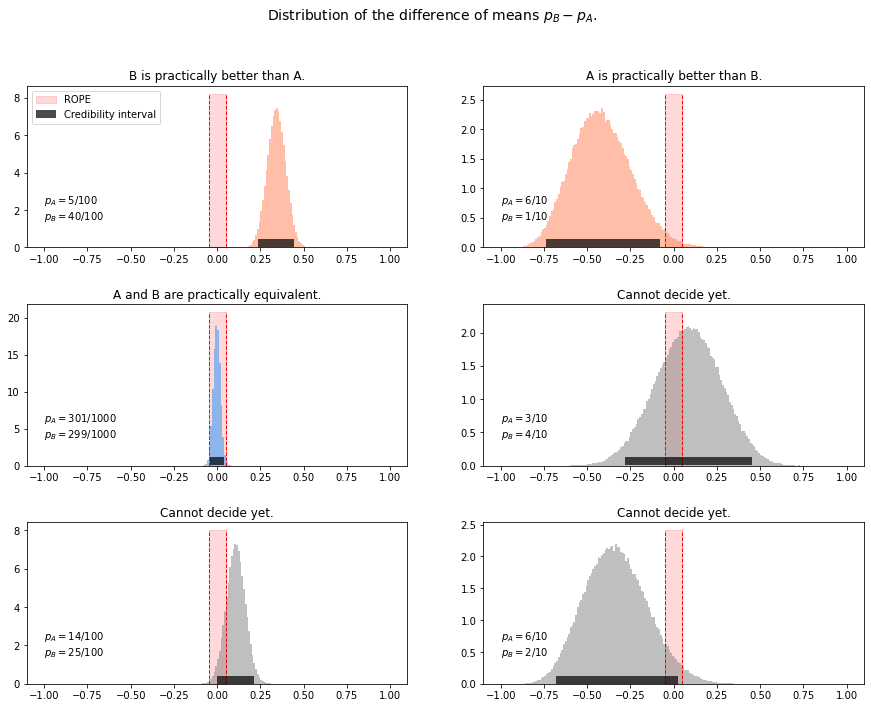

In [36]:
plt.figure(figsize=(15,11))
plt.suptitle('Distribution of the difference of means $p_B - p_A$.', fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.35)
plt.subplot(3,2,1)
plot_rope_example(5, 100, 40, 100, title='B is practically better than A.', color='coral')
plt.legend()
plt.subplot(3,2,2)
plot_rope_example(6, 10, 1, 10, title='A is practically better than B.', color='coral')
plt.subplot(3,2,3)
plot_rope_example(301, 1000, 299, 1000, title='A and B are practically equivalent.', color='dodgerblue')
plt.subplot(3,2,4)
plot_rope_example(3, 10, 4, 10, title='Cannot decide yet.', color='gray')
plt.subplot(3,2,5)
plot_rope_example(14, 100, 25, 100, title='Cannot decide yet.', color='gray')
plt.subplot(3,2,6)
plot_rope_example(6, 10, 2, 10, title='Cannot decide yet.', color='gray')
plt.savefig('figures/rope_decision_toy_examples.png', dpi=300)

# A practical example
Involving Markov chain Monte Carlos (MCMC) sampling, easy with PyMC3

## Discrete outcome

### Generate the data

In [37]:
np.random.seed(9)
samples_a = np.random.binomial(1, .3, size=5000)
samples_b = np.random.binomial(1, .31, size=5000)
samples_a.mean(), samples_b.mean()

(0.2924, 0.3182)

### Frequentist analysis

In [38]:
frequentist_analysis(samples_a.sum(), len(samples_a), samples_b.sum(), len(samples_b))

{'pvalue': 0.00544179854836149,
 'ci_lower': 0.007747411221645763,
 'ci_upper': 0.043829587661363634}

### Build the model

In [39]:
ROPE = (-.01, .01)
PRIOR_PROBA_H0 = .5

In [40]:
def prior_proba_h0_(psi_std, rope, psi_mean=0, beta_mean=0, beta_std=1, bounds=(-10, 1), resolution=10000):
    psi = sp.stats.norm.rvs(loc=psi_mean, scale=psi_std, size=resolution)
    beta = sp.stats.norm.rvs(loc=beta_mean, scale=beta_std, size=resolution)
    p_2 = 1 / (1 + np.exp(-beta - psi / 2))
    p_1 = 1 / (1 + np.exp(-beta + psi / 2))
    difference = p_2 - p_1
    bins = np.linspace(bounds[0], bounds[1], resolution)
    difference_pdf, _ = np.histogram(difference, bins=bins, density=True)
    x = 0.5 * (bins[0:-1] + bins[1:])
    in_rope = (x >= rope[0]) & (x <= rope[1])
    area_rope = np.trapz(difference_pdf[in_rope], x[in_rope])
    return area_rope

In [41]:
def elicit_prior(target_proba_h0, rope, **kwargs):
    def optim_objective(psi_std):
        return prior_proba_h0_(psi_std, rope=rope, **kwargs) - target_proba_h0
    result = sp.optimize.root_scalar(optim_objective, x0=1, method='ridder', bracket=[1e-3, 50])
    return result.root

In [42]:
psi_std = elicit_prior(target_proba_h0=PRIOR_PROBA_H0, psi_mean=0, beta_mean=0, beta_std=1.5, rope=ROPE)

In [43]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1.5)
    psi = pm.Normal("psi", mu=0, sigma=psi_std)
    
    logit_a = pm.Deterministic("logit_a", beta - psi/2)
    logit_b = pm.Deterministic("logit_b", beta + psi/2)
    
    observed_a = pm.Bernoulli("observed_a", logit_p=logit_a, observed=samples_a)
    observed_b = pm.Bernoulli("observed_b", logit_p=logit_b, observed=samples_b)
    
    proba_a = pm.Deterministic("proba_a", 1 / (1 + np.exp(-logit_a)))
    proba_b = pm.Deterministic("proba_b", 1 / (1 + np.exp(-logit_b)))
    
    difference = pm.Deterministic("difference", proba_b - proba_a)

In [44]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


### Check convergence

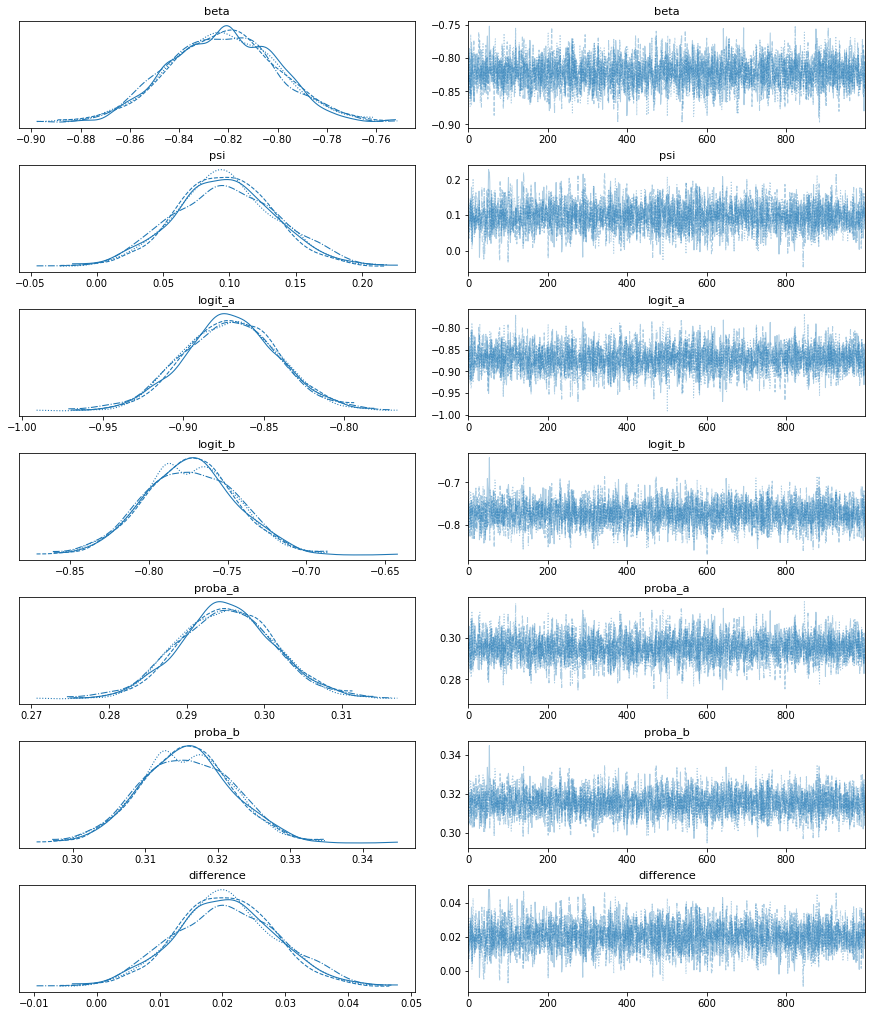

In [45]:
with model:
    pm.traceplot(trace)

### Check prior and posterior predictive distributions

In [46]:
with model:
    prior_predictive = pm.sample_prior_predictive(var_names=["observed_a", "observed_b", "difference"], samples=1000)

In [47]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["observed_a", "observed_b", "difference"])

In [48]:
def plot_distributions(data, kind, rope):
    proba_h0 = ((data['difference'] >= rope[0]) & (data['difference'] <= rope[1])).mean()
    condition = '|\mathcal{D}' if kind == 'Posterior' else ''
    
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.title(f"{kind} predictive distribution of observed outcome")
    plt.hist(data['observed_a'].mean(axis=1), color='dodgerblue', alpha=.3, density=True, bins=20,
            label=f"$p(A{condition})$")
    plt.hist(data['observed_b'].mean(axis=1), color='coral', alpha=.3, density=True, bins=20,
            label=f"$p(B{condition})$")
    _ = plt.legend()

    plt.subplot(1,2,2)
    plt.title(f"{kind} predictive distribution of the difference between means")
    y, *_ = plt.hist(data['difference'], color='coral', alpha=.3, density=True, bins=20)
    plt.vlines(rope, ymin=0, ymax=y.max() * 1.1, color='darkgreen', linestyle='dashed', linewidth=1)
    plt.fill_betweenx([0, y.max() * 1.1], rope[0], rope[1], color='green', alpha=.1,
                      label=f"$p(H_0{condition}) = {proba_h0:0.3f}$")
    _ = plt.legend()
    return proba_h0

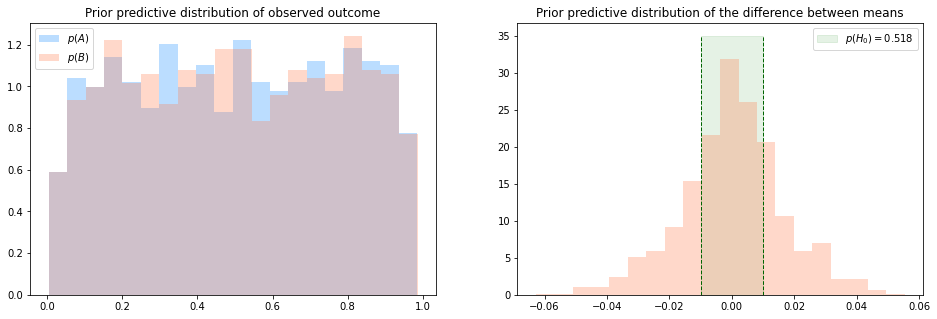

In [49]:
prior_proba_h0 = plot_distributions(prior_predictive, "Prior", rope=ROPE)

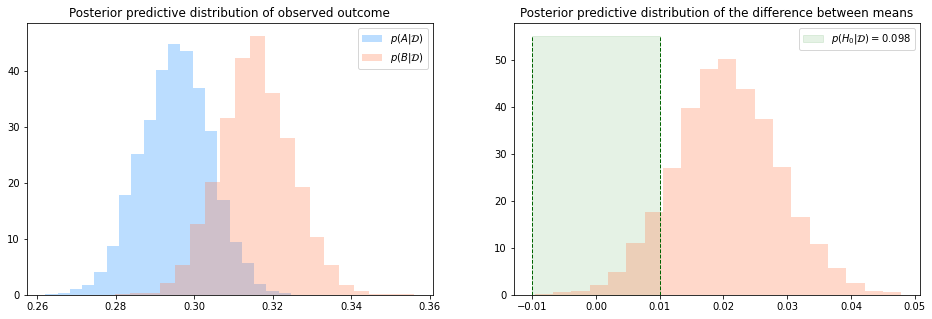

In [50]:
proba_h0 = plot_distributions(posterior_predictive, "Posterior", rope=ROPE)

### Final results

In [51]:
proba_h0

0.098

In [52]:
bayes_factor = (1 - proba_h0) / proba_h0  * prior_proba_h0 / (1 - prior_proba_h0)
bayes_factor

9.891523414344991

## Continuous outcome

In [53]:
np.random.seed(3)
samples_a = np.random.normal(loc=10, scale=5, size=1000)
samples_b = np.random.normal(loc=10, scale=5, size=1000)

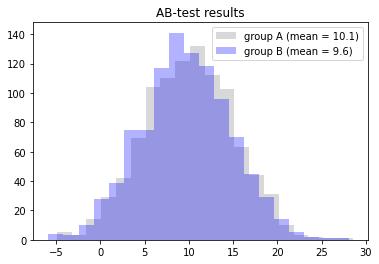

In [54]:
plt.figure(figsize=(6, 4))
plt.title(f'AB-test results')
plt.hist(samples_a, color='gray', alpha=.3, label=f'group A (mean = {samples_a.mean():.1f})', bins=20)
plt.hist(samples_b, color='blue', alpha=.3, label=f'group B (mean = {samples_b.mean():.1f})', bins=20)
_ = plt.legend()

### Frequentist analysis

In [55]:
cm = sms.CompareMeans(sms.DescrStatsW(samples_a), sms.DescrStatsW(samples_b))
cm.summary(alpha=.05, usevar='unequal')

<class 'statsmodels.iolib.table.SimpleTable'>

### Build the model

In [56]:
samples_all = np.concatenate([samples_a, samples_b])

def build_model(samples, suffix='a'):
    mean = pm.Normal("mean" + suffix, mu=samples_all.mean(), sigma=samples_all.std() * 2)
    std = pm.Uniform("std" + suffix, lower=1, upper=20)
    observed = pm.Normal("observed" + suffix, mu=mean, sigma=std, observed=samples)
    return observed

with pm.Model() as model:
    observed_a = build_model(samples_a, "_a")
    observed_b = build_model(samples_b, "_b")
    difference = pm.Deterministic("difference", model.mean_b - model.mean_a)
    rel_increase = pm.Deterministic("relative increase", difference / model.mean_a)

## Sample parameters posterior

In [57]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [std_b, mean_b, std_a, mean_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


### Checks convergence

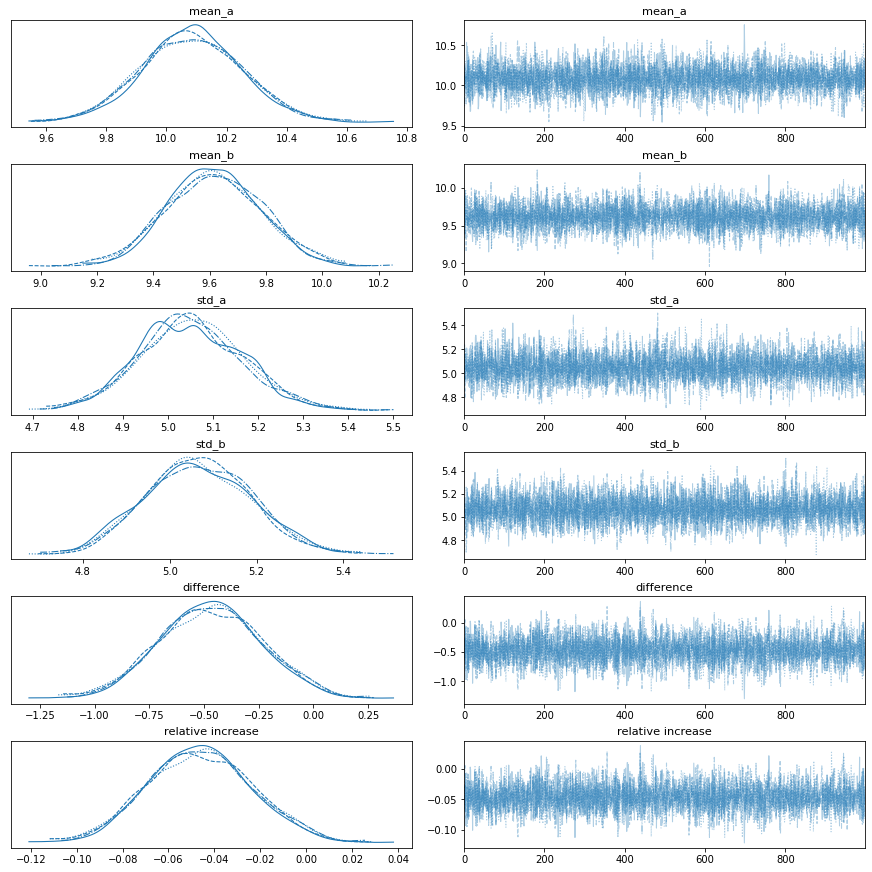

In [58]:
with model:
    pm.traceplot(trace)

### Prior predictive check

In [59]:
with model:
    prior_predictive = pm.sample_prior_predictive(var_names=["observed_a", "observed_b", "relative increase"])

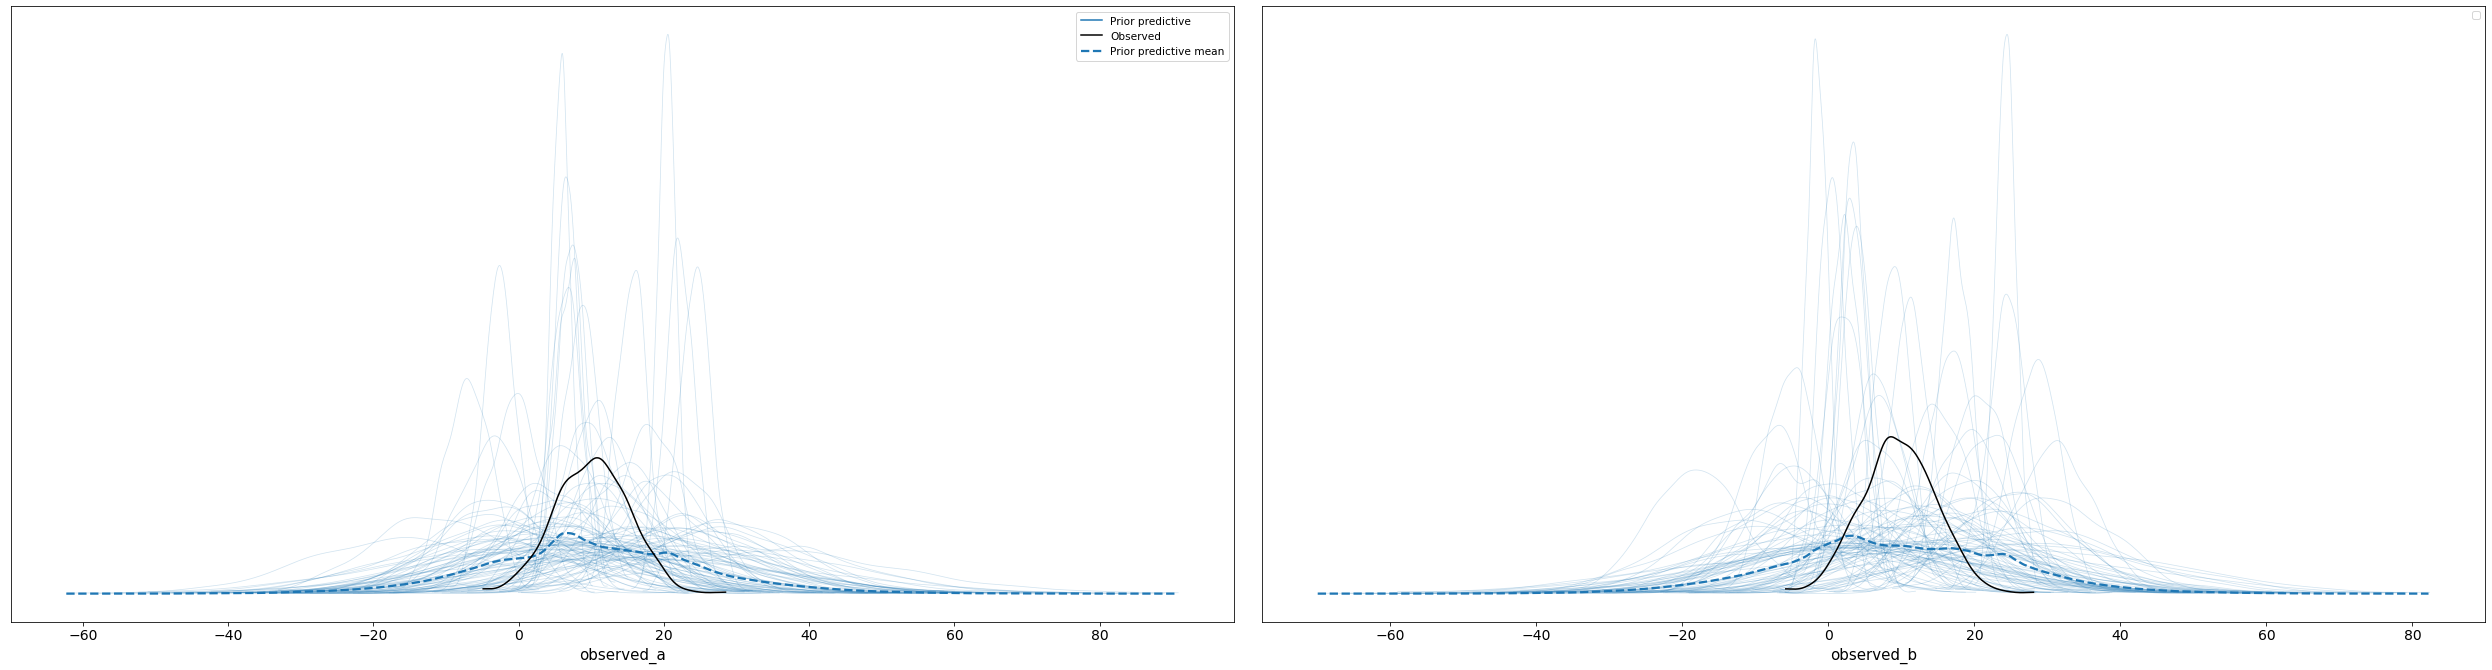

In [60]:
az.plot_ppc(az.from_pymc3(prior=prior_predictive, model=model), num_pp_samples=100, group="prior");

### Posterior predictive check

In [61]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["observed_a", "observed_b"])

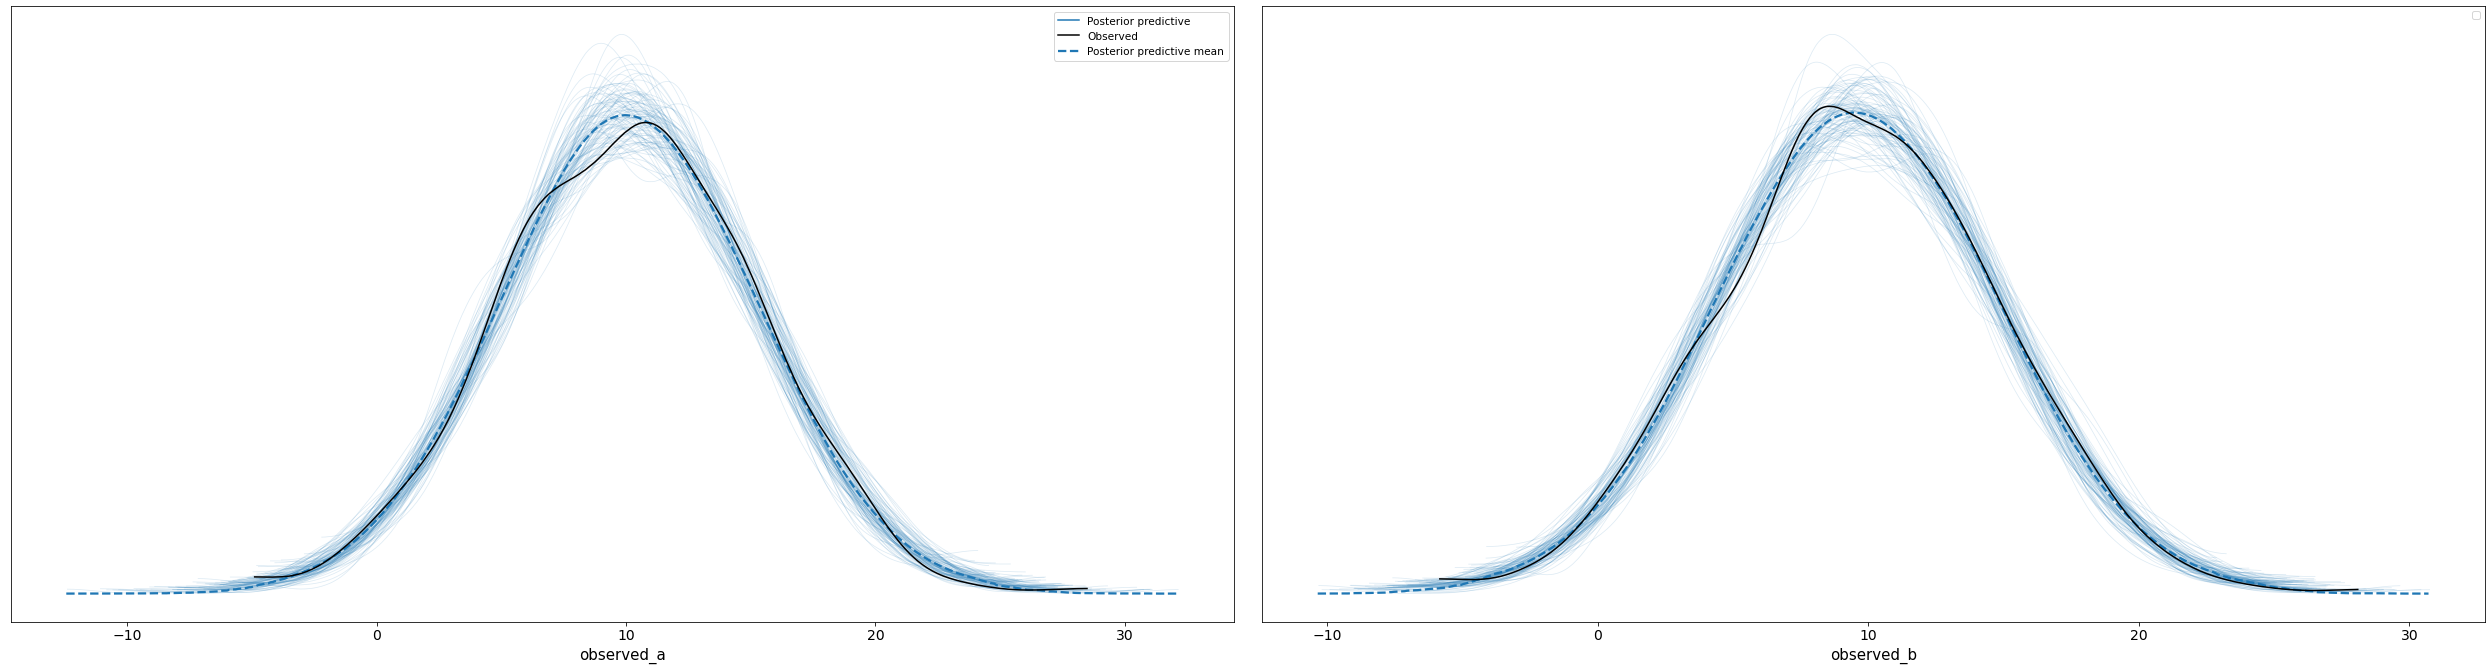

In [62]:
_ = az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_predictive, model=model),
                num_pp_samples=100, alpha=.15)

### Results and decision

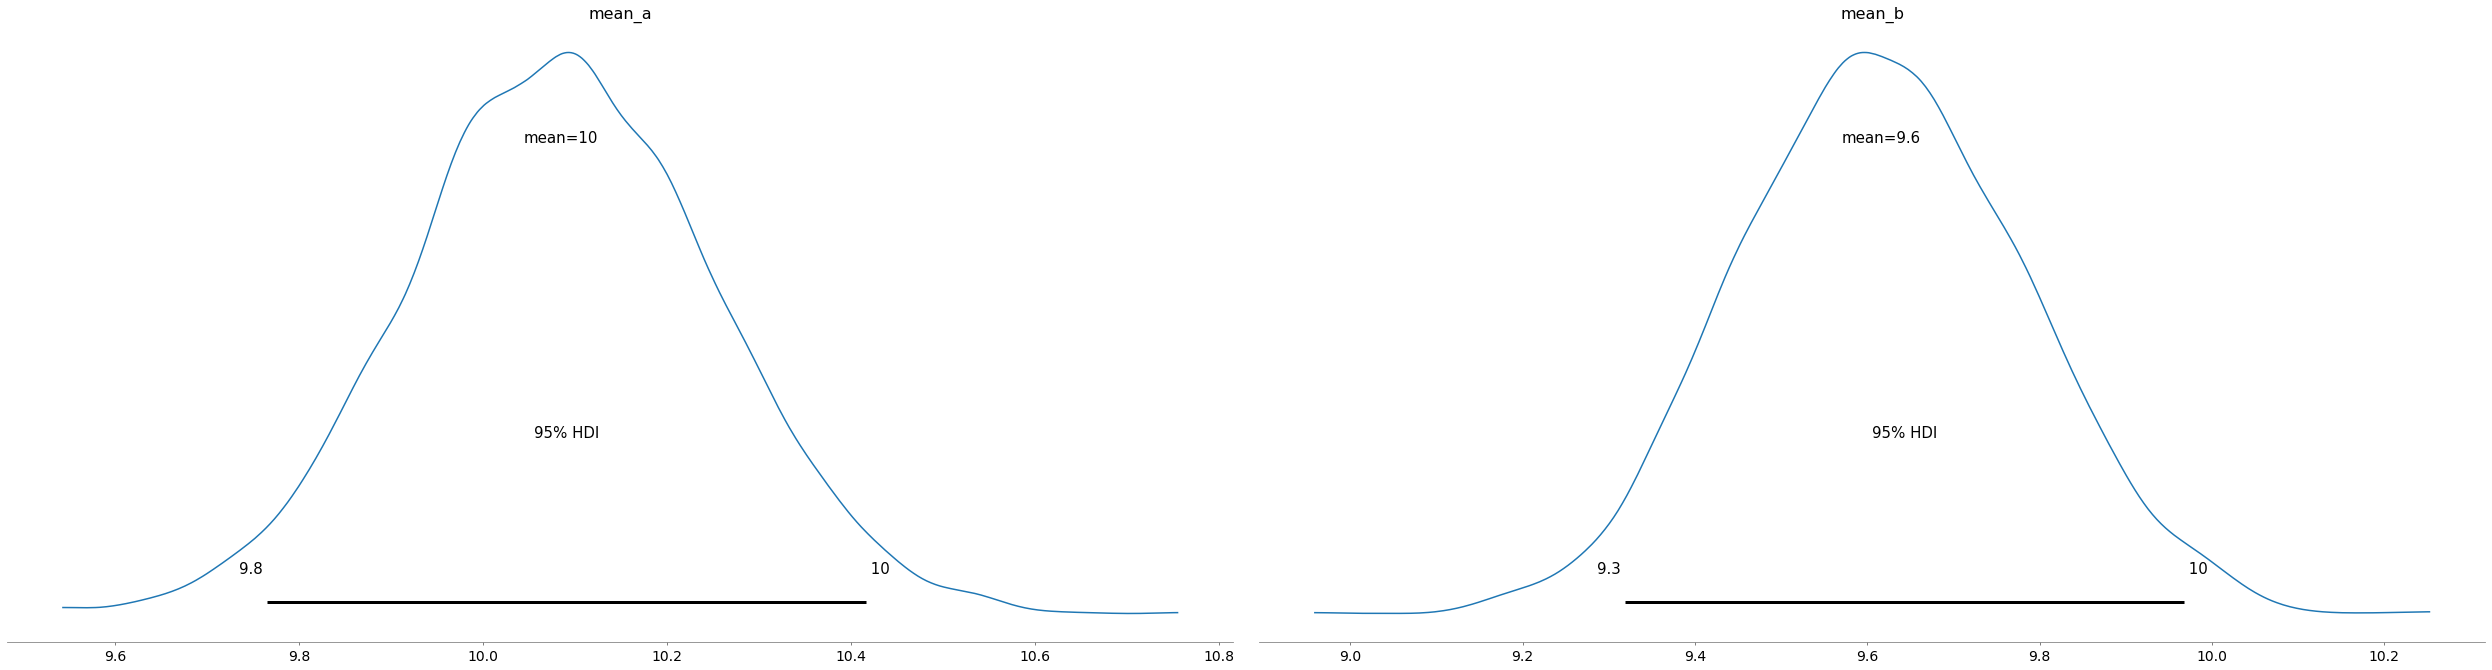

In [63]:
with model:
    _ = pm.plot_posterior(trace, var_names=["mean_a", "mean_b"], hdi_prob=.95)

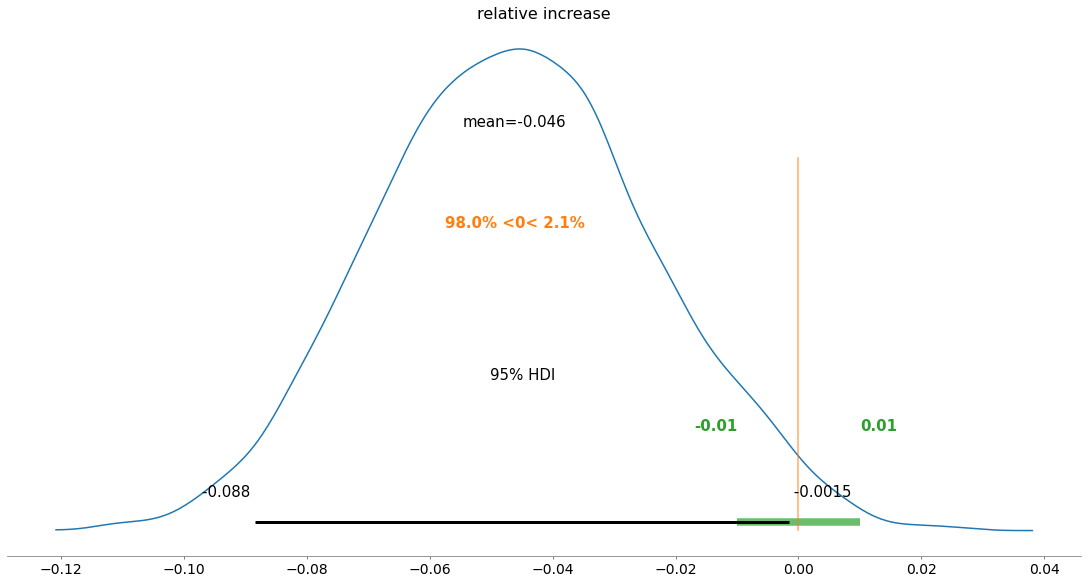

In [64]:
with model:
    az.plot_posterior(trace, var_names=["relative increase"], hdi_prob=.95, ref_val=0, rope=(-.01, .01))

In [65]:
prior_proba_h0 = ((prior_predictive['relative increase'] >= -.01) & (prior_predictive['relative increase'] <= .01)).mean()
prior_proba_h0

0.012

In [66]:
proba_h0 = ((trace['relative increase'] >= -.01) & (trace['relative increase'] <= .01)).mean()
proba_h0

0.0565

In [67]:
bayes_factor = (1 - proba_h0) / proba_h0 * prior_proba_h0 / (1 - prior_proba_h0)
bayes_factor

0.20282325964673426